In [36]:
# ============================================
# 0) Imports & setup
# ============================================
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import joblib

plt.style.use("seaborn-v0_8")
sns.set_palette("Set2")
pd.set_option("display.max_columns", None)

In [37]:
# ============================================
# 1) Load preprocessed artifacts
# - Clean (encoded) dataset
# - Clean + scaled dataset
# - Encoders & scaler
# ============================================

df = pd.read_csv("../data/german_credit_data_clean.csv")
df_scaled = pd.read_csv("../data/german_credit_data_clean_scaled.csv")

encoders = joblib.load("../models/label_encoders.pkl")
scaler    = joblib.load("../models/standard_scaler.pkl")

print(df.shape, df_scaled.shape)  # Both of them should be (1000, 9)
df.head(2)

(1000, 9) (1000, 9)


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,1,2,1,4,0,1169,6,5
1,22,0,2,1,0,1,5951,48,5


In [38]:
# ============================================
# 2) First clustering baseline (KMeans)
# We'll start simple with 3 clusters; we'll tune later with elbow/silhouette.
# ============================================
X = df_scaled[["Age", "Duration", "Credit amount", "Sex", "Job", "Housing",
               "Saving accounts", "Checking account", "Purpose"]].values

kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto")
labels = kmeans.fit_predict(X)

df_clusters = df.copy()
df_clusters["cluster"] = labels

# quick view of cluster sizes
df_clusters["cluster"].value_counts().sort_index()


cluster
0    147
1    408
2    445
Name: count, dtype: int64

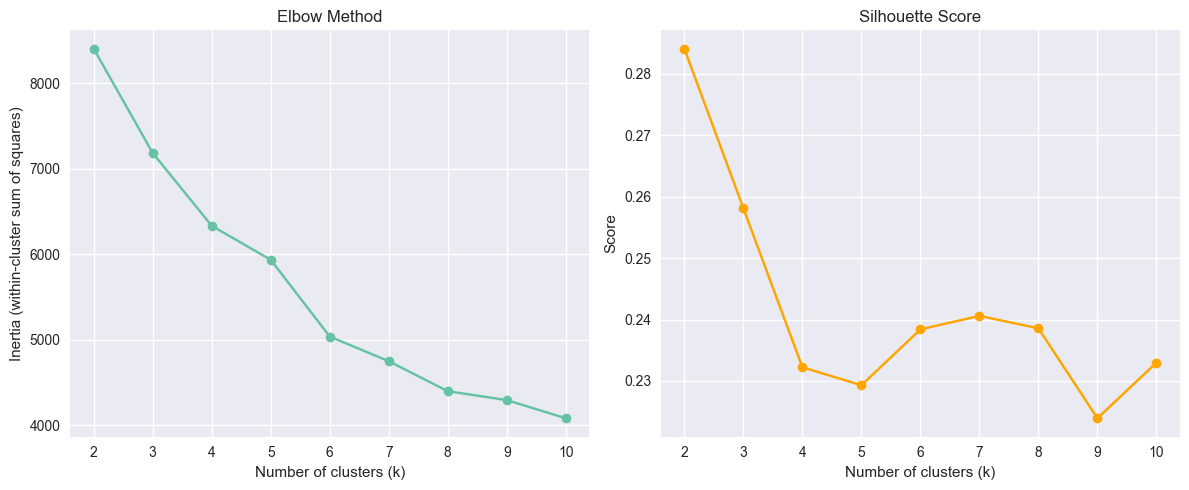

In [39]:
# ============================================
# 3) Optimize cluster count: Elbow & Silhouette
# ============================================

X = df_scaled[["Age", "Duration", "Credit amount", "Sex", "Job", "Housing",
               "Saving accounts", "Checking account", "Purpose"]].values

inertia = []        # # total error for each k
silhouette_scores = []  # silhouette score for each k

K = range(2, 11)  # test cluster numbers from 2 to 10

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(X)
    
    inertia.append(kmeans.inertia_)  # total error
    silhouette_scores.append(silhouette_score(X, labels))  # quality

# --- Let's plot the graphs ---
plt.figure(figsize=(12,5))

# Elbow
plt.subplot(1,2,1)
plt.plot(K, inertia, marker="o")
plt.title("Elbow Method")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (within-cluster sum of squares)")

# Silhouette
plt.subplot(1,2,2)
plt.plot(K, silhouette_scores, marker="o", color="orange")
plt.title("Silhouette Score")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Score")

plt.tight_layout()
plt.show()


## Cluster Number Optimization (Elbow & Silhouette)

Initially, I chose 3 clusters for KMeans, but I wanted to check whether this choice was correct. Therefore, I applied the **Elbow Method** and **Silhouette Score**.  

- In the Elbow chart, I observed a clear bend around **k=3 or k=4**.  
- In the Silhouette score, the highest value appeared at **k=2**, but this would have resulted in overly simplistic clusters. A more balanced and meaningful choice was clearly **k=3**.  

After this analysis, I confirmed that my initial choice of **3 clusters was indeed reasonable**.


In [40]:
# ============================================
# 4) Persist model (save KMeans for later use)
# ============================================

# 1. Train final KMeans model with chosen k (e.g., 3 clusters)
final_k = 3
final_kmeans = KMeans(n_clusters=final_k, random_state=42, n_init="auto")
final_labels = final_kmeans.fit_predict(X)

# 2. Save the model to models/ folder
joblib.dump(final_kmeans, "../models/kmeans_model.pkl")
print("Model saved: ../models/kmeans_model.pkl")

# 3. Add final cluster labels to dataframe for analysis
df_clusters_final = df.copy()
df_clusters_final["cluster"] = final_labels

# Quick view of cluster sizes
print("\nCluster sizes:")
print(df_clusters_final["cluster"].value_counts().sort_index())


Model saved: ../models/kmeans_model.pkl

Cluster sizes:
cluster
0    147
1    408
2    445
Name: count, dtype: int64


cluster
0    147
1    408
2    445
Name: count, dtype: int64

Age                       Duration                        \
          mean median    std min max     mean median    std min max   
cluster                                                               
0        37.50   35.0  11.69  19  67    20.45   18.0  11.90   6  60   
1        33.49   31.0  10.66  19  67    19.75   18.0  11.42   4  72   
2        36.79   35.0  11.63  20  75    22.11   20.0  12.58   4  60   

        Credit amount                               
                 mean  median      std  min    max  
cluster                                             
0             2845.40  2030.0  2464.39  368  14179  
1             2802.85  2098.0  2386.83  338  18424  
2             3841.39  2760.0  3181.34  250  15945


Categorical share by cluster → Sex


Sex,0,1
cluster,,
0,31.97,68.03
1,36.03,63.97
2,26.07,73.93



Categorical share by cluster → Job


Job,0,1,2,3
cluster,,,,
0,1.36,19.73,69.39,9.52
1,1.47,20.59,65.69,12.25
2,3.15,19.55,58.43,18.88



Categorical share by cluster → Housing


Housing,0,1,2
cluster,,,
0,7.48,76.19,16.33
1,8.82,73.04,18.14
2,13.71,68.09,18.20



Categorical share by cluster → Saving accounts


Saving accounts,0,1,2,3,4
cluster,,,,,
0,0.00,0.00,19.05,16.33,64.63
1,86.52,10.78,2.70,0.00,0.00
2,56.18,13.26,5.39,5.39,19.78



Categorical share by cluster → Checking account


Checking account,0,1,2,3
cluster,,,,
0,12.93,23.13,6.80,57.14
1,32.35,27.21,7.11,33.33
2,27.64,27.87,5.39,39.10



Categorical share by cluster → Purpose


Purpose,0,1,2,3,4,5,6,7
cluster,,,,,,,,
0,0.0,0.00,2.04,13.61,27.21,52.38,3.40,1.36
1,0.0,0.00,0.00,9.07,34.56,49.75,4.17,2.45
2,21.8,75.73,2.02,0.45,0.00,0.00,0.00,0.00



Sex classes mapping: {0: 'female', 1: 'male'}
Categorical share by cluster → Sex (readable)


Sex,female,male
cluster,,
0,31.97,68.03
1,36.03,63.97
2,26.07,73.93


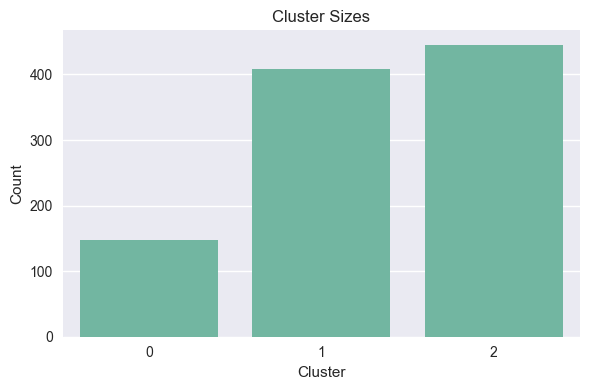

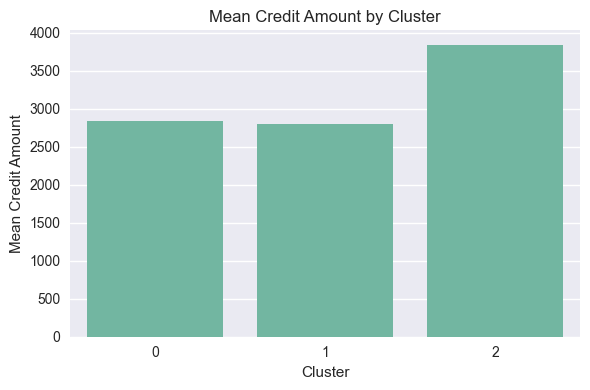

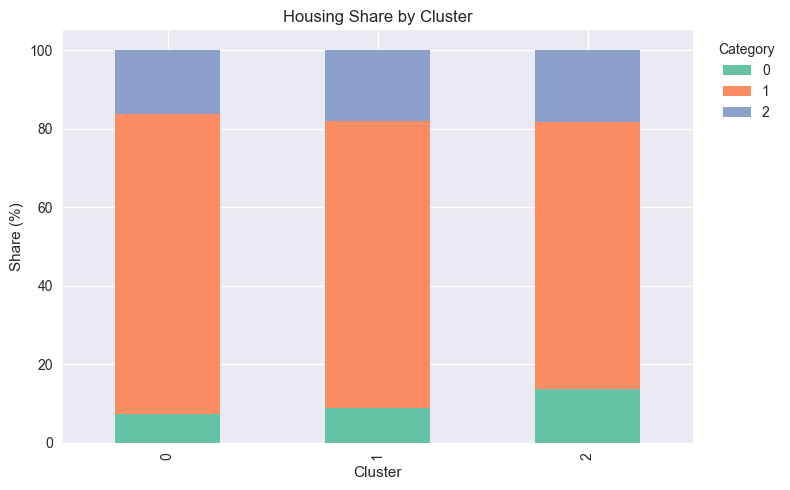

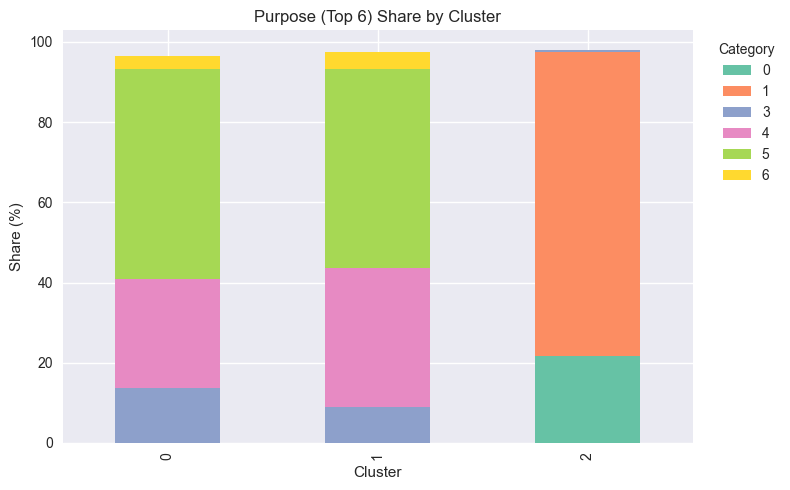


Saved:
 - ../data/cluster_sizes.csv
 - ../data/cluster_numeric_summary.csv
 - ../data/cluster_cat_Sex_share.csv
 - ../data/cluster_cat_Job_share.csv
 - ../data/cluster_cat_Housing_share.csv
 - ../data/cluster_cat_Saving accounts_share.csv
 - ../data/cluster_cat_Checking account_share.csv
 - ../data/cluster_cat_Purpose_share.csv
 - ../images/cluster_summaries/*.png


In [ ]:
# ============================================
# 5) Cluster-level summaries (numeric & categorical)
# ============================================

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
sns.set_palette("Set2")

# --- Columns we’ll summarize
num_cols = ["Age", "Duration", "Credit amount"]
cat_cols = ["Sex", "Job", "Housing", "Saving accounts", "Checking account", "Purpose"]

# --- Safety: make sure cluster labels exist
assert "cluster" in df_clusters.columns, "df_clusters['cluster'] yok. Önce KMeans ile 'cluster' üret."

# --- Output folders
os.makedirs("../images/cluster_summaries", exist_ok=True)
os.makedirs("../data", exist_ok=True)

# 5.1) Cluster sizes
cluster_sizes = (
    df_clusters["cluster"]
    .value_counts()
    .sort_index()
    .rename("count")
)
display(cluster_sizes)

# save
cluster_sizes.to_csv("../data/cluster_sizes.csv", index=True)

# 5.2) Numerical summaries per cluster
num_summary = (
    df_clusters.groupby("cluster")[num_cols]
    .agg(["mean", "median", "std", "min", "max"])
    .round(2)
)
display(num_summary)

# save
num_summary.to_csv("../data/cluster_numeric_summary.csv")

# 5.3) Categorical distributions per cluster (row-normalized = percentages)
cat_tables = {}
for col in cat_cols:
    # cross-tab: cluster (rows) x category (columns)
    ct = pd.crosstab(df_clusters["cluster"], df_clusters[col])
    ct_pct = (ct.div(ct.sum(axis=1), axis=0) * 100).round(2)
    cat_tables[col] = ct_pct
    # show a small preview
    print(f"\nCategorical share by cluster → {col}")
    display(ct_pct.head())

    # save
    ct_pct.to_csv(f"../data/cluster_cat_{col}_share.csv")

# 5.4) Simple visuals (and save)
# (A) Cluster sizes bar
plt.figure(figsize=(6,4))
sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values)
plt.title("Cluster Sizes")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("../images/cluster_summaries/cluster_sizes.png", dpi=150)
plt.show()

# (B) Mean credit amount per cluster
mean_credit = df_clusters.groupby("cluster")["Credit amount"].mean().round(0)
plt.figure(figsize=(6,4))
sns.barplot(x=mean_credit.index, y=mean_credit.values)
plt.title("Mean Credit Amount by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Mean Credit Amount")
plt.tight_layout()
plt.savefig("../images/cluster_summaries/mean_credit_amount_by_cluster.png", dpi=150)
plt.show()

# (C) Stacked share plots for a couple of important categoricals
def stacked_share_plot(share_table, title, outfile):
    """share_table: rows=clusters, columns=categories, values=percent"""
    ax = share_table.plot(kind="bar", stacked=True, figsize=(8,5))
    plt.title(title)
    plt.xlabel("Cluster")
    plt.ylabel("Share (%)")
    plt.legend(title="Category", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.savefig(outfile, dpi=150)
    plt.show()

# Pick 1–2 categorical columns that are business-meaningful
if "Housing" in cat_tables:
    stacked_share_plot(
        cat_tables["Housing"],
        "Housing Share by Cluster",
        "../images/cluster_summaries/housing_share_by_cluster.png"
    )

if "Purpose" in cat_tables:
    # optional: limit to top-N purposes for readability
    top_purposes = (
        df_clusters["Purpose"]
        .value_counts()
        .head(6)
        .index
    )
    purpose_share = cat_tables["Purpose"][cat_tables["Purpose"].columns.intersection(top_purposes)]
    stacked_share_plot(
        purpose_share,
        "Purpose (Top 6) Share by Cluster",
        "../images/cluster_summaries/purpose_share_by_cluster.png"
    )

print("\nSaved:")
print(" - ../data/cluster_sizes.csv")
print(" - ../data/cluster_numeric_summary.csv")
for c in cat_cols:
    print(f" - ../data/cluster_cat_{c}_share.csv")
print(" - ../images/cluster_summaries/*.png")
